In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import PIL

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

import cortex

from plotting import plot_utils, summary_plots, load_fits, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils

#### Load model fits

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_types = ['texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs', 
                 'gist_4ori_2blocks_pRFgrid_0', 
                 'gist_4ori_pRFgrid_0', 
                 'gabor_solo_ridge_4ori_4sf_use_texture_pRFs'] + \
                 ['alexnet_Conv%d_pca_use_texture_pRFs'%ll for ll in np.arange(1,3)]
short_names = ['texture', \
               'gist (4 orient, 2x2 grid)', \
               'gist (4 orient, 4x4 grid)', \
               'gabor'] + ['alexnet conv%d'%ll for ll in np.arange(1,3)]

out = [[load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) \
                                   for ss in subjects] for fitting_type in fitting_types]
# shuffled model fits, to compute significance of model fit each ROI.
fitting_type_shuffle = 'texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_pRFs_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type_shuffle, \
                                  n_from_end=0, verbose=False) \
                                    for ss in subjects]

#### Make ROI definitions

In [3]:
roi_def = roi_utils.multi_subject_roi_def(subjects, areas_include = ['V1','V2','V3','hV4', \
                                                      'OPA','PPA','RSC',\
                                                      'FFA','EBA'], use_kastner_areas=False, \
                                         remove_ret_overlap=True, remove_categ_overlap=True)
roi_names = roi_def.roi_names;
n_rois = len(roi_names)

#### Process results of permutation test, compute p-values

In [4]:
pvals_singlevoxels_modelsig = [[] for si in range(n_subjects)]

pvals_rois_modelsig = np.zeros((n_subjects, n_rois))

propvox_modelsig = np.zeros((n_subjects, n_rois))

for si in range(n_subjects):

    # stats for single voxels
    r2_real = out[0][si]['val_r2']
    r2_shuff = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p = np.mean(r2_real[:,0,None]<=r2_shuff[:,0,:], axis=1)
    _,pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, \
                                                   method='poscorr')
    
    pvals_singlevoxels_modelsig[si] = pvals_fdr
     
    for rr in range(n_rois):
           
        # for each ROI - how many individual voxels is the model above-chance for?
        # (of those that had reasonable noise ceiling)
        abv_thresh = summary_plots.get_noise_ceiling(out[0][si])>0.01
        inds = roi_def.ss_roi_defs[si].get_indices(rr) & abv_thresh
            
        propvox_modelsig[si,rr] = np.mean(pvals_fdr[inds]<0.01)
        
        # is average R2 of the ROI above chance? 
        avg_r2_real = np.mean(r2_real[inds,0], axis=0)
        avg_r2_shuff = np.mean(r2_shuff[inds,0,:], axis=0)
        
        pvals_rois_modelsig[si,rr] = np.mean(avg_r2_real<=avg_r2_shuff)
        
        
_, pvals_rois_modelsig_fdr = stats_utils.fdr_keepshape(pvals_rois_modelsig, alpha=0.01, \
                                                       method='poscorr')

#### Plot R2 averaged over ROIs

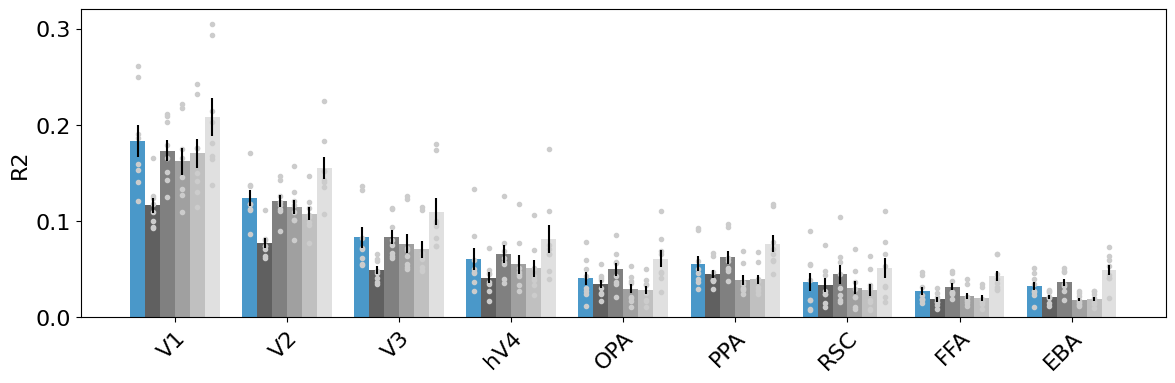

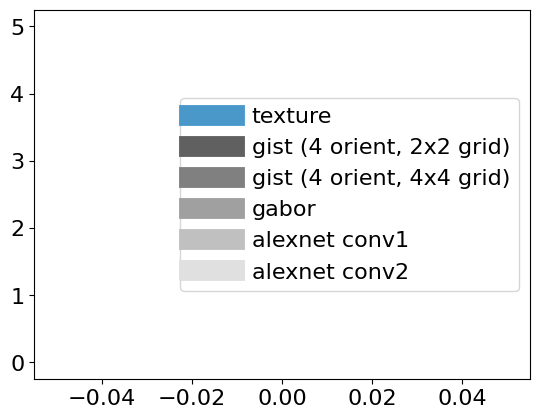

In [5]:
plt.rcParams['pdf.fonttype']=42

ff2plot = [0,1,2,3,4,5] # which fitting types are we plotting? all of them

model_colors = cm.gray(np.linspace(0,1,len(ff2plot)+3))[2:len(ff2plot)+2,:]
model_colors[0,:] = cm.Blues(np.linspace(0,1,6))[3,:]

nc_thresh = 0.01
ylims = [0, 0.32]

vals = np.zeros((n_subjects, n_rois, len(ff2plot)))

for si in range(n_subjects):
    
    nc = summary_plots.get_noise_ceiling(out[0][si])
    inds2use = nc>nc_thresh

    for fi, ff in enumerate(ff2plot):

        val_r2 = out[ff][si]['val_r2']  

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
            assert(np.sum(inds_this_roi)>0)
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi,0], axis=0)

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)
 
plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = vals, 
                                colors=model_colors,
                                space=0.1, \
                                # legend_separate=False,\
                                legend_labels = [short_names[ff] for ff in ff2plot],
                xticklabels=roi_names, ylabel='R2', \
                ylim=ylims, horizontal_line_pos=None,\
                fig_size=(14,4))

fn2save = os.path.join(default_paths.fig_path, 'allmodels_barplot.pdf')
plt.savefig(fn2save)

In [12]:
np.min(nc)

0.0

#### Make a few scatter plots of single voxels

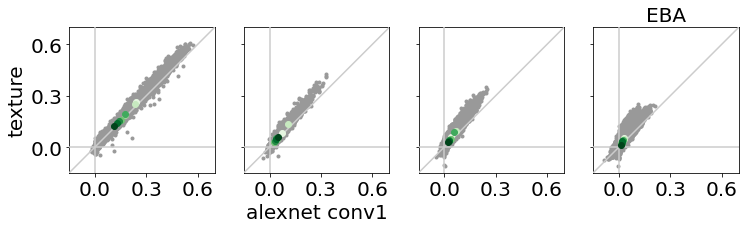

In [13]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(20)

# just plot a few ROIs, because these will create very big files
rois2plot = [0, 3, 5, 8]

axlims = [-0.15,0.70]

ff1 = 0; 

for ff2 in [4]:

    # concat all voxels
    val_r2_1 = np.concatenate([o['val_r2'][:,0] for o in out[ff1]], axis=0)
    val_r2_2 = np.concatenate([o['val_r2'][:,0] for o in out[ff2]], axis=0)

    dat2plot = np.concatenate([val_r2_2[:,np.newaxis],val_r2_1[:,np.newaxis]], axis=1)

    nc_thresh = 0.01
    nc = np.concatenate([summary_plots.get_noise_ceiling(out[0][si]) for si in range(n_subjects)], axis=0)
    inds2use = nc>nc_thresh

    # color diff subjects differently
    n_subs = len(out[0])
    n_vox_each = np.array([o['val_r2'].shape[0] for o in out[0]])
    subject_inds = np.repeat(np.arange(n_subs), n_vox_each)

    sub_colors = cm.Greens(np.linspace(0,1,n_subs+1))[1:,:]
   
    plt.figure(figsize=(12,6))
    
    for ri, rr in enumerate(rois2plot):

        plt.subplot(1,len(rois2plot), ri+1)
        inds_this_roi = roi_def.get_indices(rr)

        data_this_roi = dat2plot[inds2use & inds_this_roi,:]
        subject_inds_this_roi = subject_inds[inds2use & inds_this_roi]

        plt.plot(data_this_roi[:,0], data_this_roi[:,1], '.', \
                 color=[0.6, 0.6, 0.6], alpha=1.0,  zorder=-10)

        for si, ss in enumerate(subjects):

            subdata = data_this_roi[subject_inds_this_roi==si,:]
            means = np.mean(subdata, axis=0)
            plt.plot(means[0], means[1], 'o', color=sub_colors[si,:],zorder=15)

        plt.axis('square')
        plt.xlim(axlims)
        plt.ylim(axlims)
        plt.plot(axlims, axlims, color=[0.8, 0.8, 0.8],zorder=5)
        plt.axvline(0, color=[0.8, 0.8, 0.8],zorder=5)
        plt.axhline(0, color=[0.8, 0.8, 0.8],zorder=5)
        # plt.xticks([0,0.5,1])
        plt.xticks([0,0.3,0.6])

        if ri==1:
            plt.xlabel(short_names[ff2])
        plt.ylabel(short_names[ff1])

        if ri>0:
            plt.ylabel('')
            plt.yticks([0,0.3,0.6],[])
        else:
            plt.yticks([0,0.3,0.6])

    plt.title('%s'%(roi_names[rr]))


    fn2save = os.path.join(default_paths.fig_path, 'texture_alexnetL1_r2_scatter.pdf')
    plt.savefig(fn2save)

#### Plot proportion significant voxels

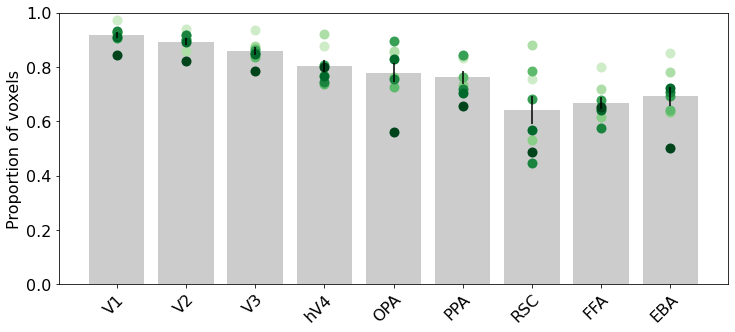

In [14]:
plt.rcParams['pdf.fonttype']=42

ylims = [0, 1.0]

vals = propvox_modelsig[:,:,None]

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                colors=np.array([[0.8, 0.8, 0.8]]), space=0.1, \
                xticklabels=roi_names, ylabel='Proportion of voxels', \
                ylim=ylims, horizontal_line_pos=None,\
                fig_size=(12,5))

# now adding single subjects to the plot too
subcolors = cm.Greens(np.linspace(0,1,n_subjects+2))[2:,:]
for ss in range(n_subjects):
    plt.plot(np.arange(n_rois), vals[ss,:,0],'o',markersize=10, markeredgecolor='none', \
             markerfacecolor=subcolors[ss,:], zorder=15)
    
fn2save = os.path.join(default_paths.fig_path, 'texture_propsig_summary.pdf')
plt.savefig(fn2save)


#### Use PyCortex to make surface plots

In [8]:
volumes = {}

for si, ss in enumerate(subjects):

    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []

    names += ['S%d: Full model (sqrt R2)'%ss]
    # take sqrt of absolute value (this prevents nans) but keep sign
    r2 = out[0][si]['val_r2'][:,0]
    maps += [np.sign(r2) * np.sqrt(np.abs(r2))]
    cmaps += ['Blues']
    mins += [0]
    maxes += [0.60]
    
    perm_sig_overall = pvals_singlevoxels_modelsig[si]<0.01

    abv_thresh = summary_plots.get_noise_ceiling(out[0][si])>0.01
    vox2plot = abv_thresh & perm_sig_overall
   
    voxel_mask = out[0][si]['voxel_mask']
    nii_shape = out[0][si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)
    

#### Make the static webviewer html

In [7]:
save_html_name = os.path.join(default_paths.fig_path, 'Texture_model_R2_allsubs.html')
title = 'Texture statistics encoding model, validation set R2'
viewer = cortex.webgl.make_static(outpath= save_html_name, \
                            data = volumes, 
                            recache = False,
                            title = title)
    

#### Make a webviewer

In [9]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Texture model summary', \
                                                port = 44443, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:44443
Started server on port 44443
Stopping server


#### Set view and save images of flatmaps

In [19]:
# load pre-made view params from a json file
# (json files are in your pycortex database folder, under subj01/views/)

viewname='flat'
# viewname='left-tilt'
# viewname='right-tilt'
# viewname='bottom'

viewer.get_view('subj01',viewname)

# to make the view:
# viewer.save_view('subj01','flat1',True)

In [21]:
ss=1;
fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_texture_r2_%s_raw.png'%(ss,viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/texturemodel/figures/S01_texture_r2_flat_raw.png


[{}]

In [22]:
# cropping the images
subject_bboxes = {'subj01':[620,900,2220,2500], 'subj02':[620,900,2220,2500], \
                  'subj03': [620,800,2220,2400], 'subj04': [620,750,2220,2350], \
                  'subj05': [620,800,2220,2400], 'subj06': [620,1050,2220,2650], \
                  'subj07': [620,800,2220,2400], 'subj08': [620,900,2220,2500]}

In [23]:

for ss in subjects:
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_texture_r2_%s_raw.png'%(ss,viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_r2_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000
3000
3000
3000
3000
3000
3000


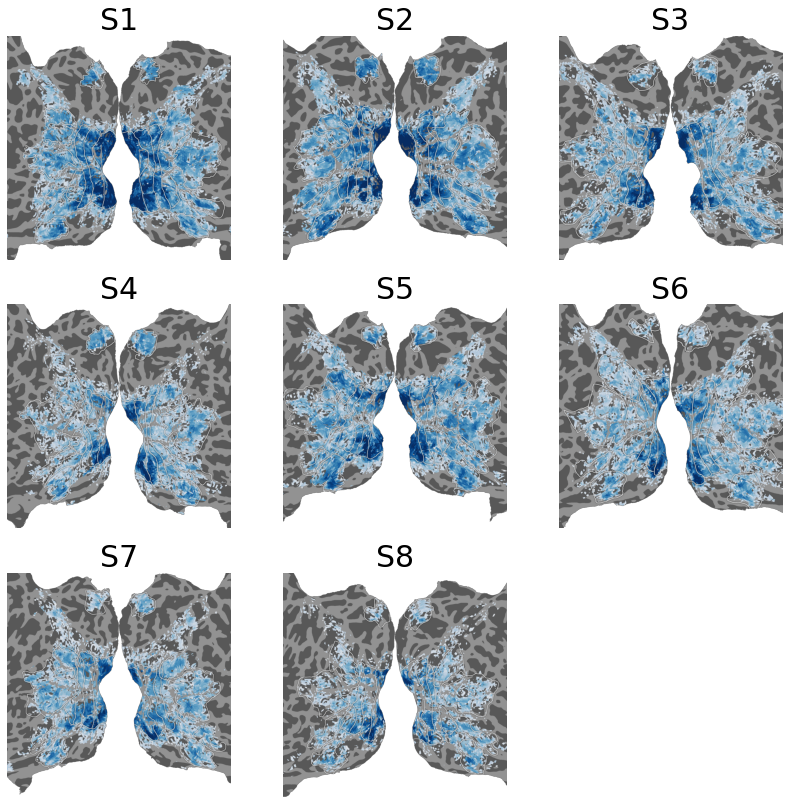

In [24]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 30)

plt.figure(figsize=(14,14))

for ss in subjects:
    
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_r2_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save_cropped)

    plt.subplot(3,3,ss);
    plt.imshow(im)
    plt.title('S%d'%ss)
    plt.axis('off')
    
fn2save = os.path.join(default_paths.fig_path, 'texture_r2_allsubs.pdf')
plt.savefig(fn2save,dpi=1000)

In [33]:
# cropping the images
subject_bboxes = {'subj01':[200,200,2800,2800]}

In [36]:
ss=1;

for vi, viewname in enumerate(['left-tilt', 'right-tilt', 'bottom']):

    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_texture_r2_%s_raw.png'%(ss,viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_r2_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000
3000


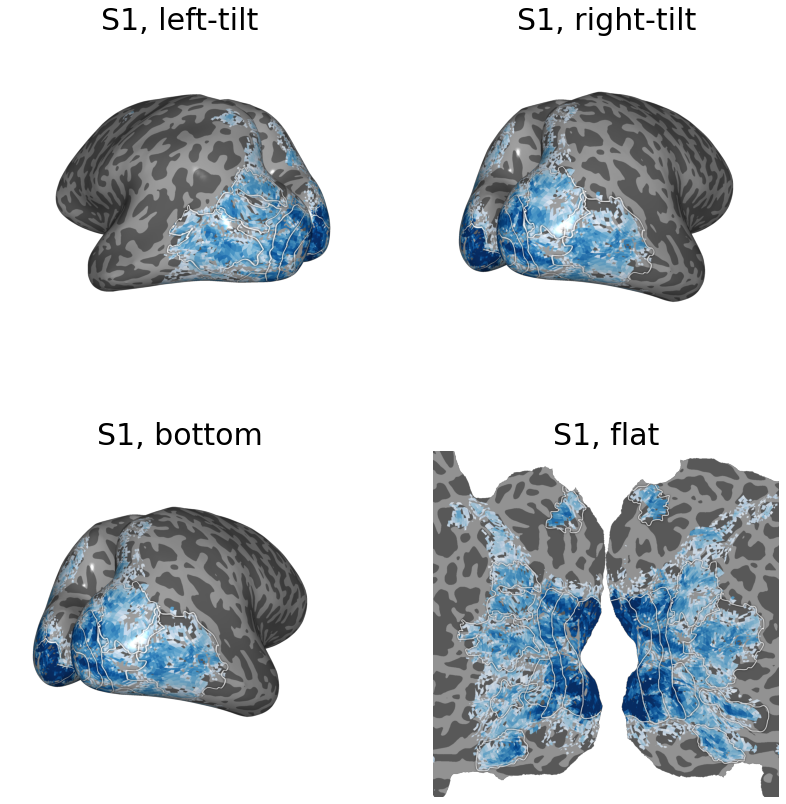

In [38]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 30)

plt.figure(figsize=(14,14))

ss = 1;

for vi, viewname in enumerate(['left-tilt', 'right-tilt', 'bottom', 'flat']):
    
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_r2_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save_cropped)

    plt.subplot(2,2,vi+1);
    plt.imshow(im)
    plt.title('S%d, %s'%(ss, viewname))
    plt.axis('off')
    
fn2save = os.path.join(default_paths.fig_path, 'texture_r2_S1_views.pdf')
plt.savefig(fn2save,dpi=1000)